In [13]:
import pathlib as pl
from configparser import ConfigParser
from functools import reduce
import itertools as itt

from tqdm import tqdm
import joblib as jl
import numpy as np
import scipy.stats as sst
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.data.load import get_CPN_ids
from src.root_path import config_path, root_path
from src.visualization.palette import ColorList

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

#### get a list of all the recorded neurons and the sounds used<br/>
specifficaly for the subset of neurons recorded with all permutations of 10 sounds


In [14]:
df = get_CPN_ids(10, 'AllPermutations')
df['sound_sets'] = df['Ref_SoundIndexes'].apply(lambda x: set(x))
df['set_size'] =[len(s) for s in df.sound_sets]
df.head()

,siteid,cellid,rawid,Ref_SoundIndexes,sound_sets,set_size
0,TNC014a,TNC014a-40-5,143942,"[1, 2, 3, 4, 5, 6, 7, 12, 14, 15]","{1, 2, 3, 4, 5, 6, 7, 12, 14, 15}",10
1,TNC014a,TNC014a-45-3,143942,"[1, 2, 3, 4, 5, 6, 7, 12, 14, 15]","{1, 2, 3, 4, 5, 6, 7, 12, 14, 15}",10
2,TNC014a,TNC014a-45-4,143942,"[1, 2, 3, 4, 5, 6, 7, 12, 14, 15]","{1, 2, 3, 4, 5, 6, 7, 12, 14, 15}",10
3,TNC014a,TNC014a-38-1,143942,"[1, 2, 3, 4, 5, 6, 7, 12, 14, 15]","{1, 2, 3, 4, 5, 6, 7, 12, 14, 15}",10
4,TNC014a,TNC014a-39-2,143942,"[1, 2, 3, 4, 5, 6, 7, 12, 14, 15]","{1, 2, 3, 4, 5, 6, 7, 12, 14, 15}",10


In [15]:
df.query('set_size == 9').head()

,siteid,cellid,rawid,Ref_SoundIndexes,sound_sets,set_size
328,TNC008a,TNC008a-01-1,143670,"[4, 11, 14, 5, 12, 8, 15, 3, 11, 1]","{1, 3, 4, 5, 8, 11, 12, 14, 15}",9
329,TNC008a,TNC008a-05-1,143670,"[4, 11, 14, 5, 12, 8, 15, 3, 11, 1]","{1, 3, 4, 5, 8, 11, 12, 14, 15}",9
330,TNC008a,TNC008a-06-1,143670,"[4, 11, 14, 5, 12, 8, 15, 3, 11, 1]","{1, 3, 4, 5, 8, 11, 12, 14, 15}",9
331,TNC008a,TNC008a-06-2,143670,"[4, 11, 14, 5, 12, 8, 15, 3, 11, 1]","{1, 3, 4, 5, 8, 11, 12, 14, 15}",9
332,TNC008a,TNC008a-07-1,143670,"[4, 11, 14, 5, 12, 8, 15, 3, 11, 1]","{1, 3, 4, 5, 8, 11, 12, 14, 15}",9


#### oohps it s seems I repreatede one sound for TNC008. gotta be carefull with what examples I pull

#### try to get a common subset of sounds across all data
there exists none

In [16]:
unique_sorted_seqs = df.sound_sets.drop_duplicates()
common = reduce(lambda x,y: x.intersection(y), unique_sorted_seqs)
print(f'common set: {common}')

common set: set()


# since there is no commo subset...
 get defines the one which gets the most sites/sounds

In [17]:
#onehot encoding
def my_onehot(sounds):
    ohv = np.zeros(16).astype(int)
    ohv[np.asarray(sounds)-1] = 1
    return ohv

df['onehot'] = df['Ref_SoundIndexes'].apply(my_onehot)

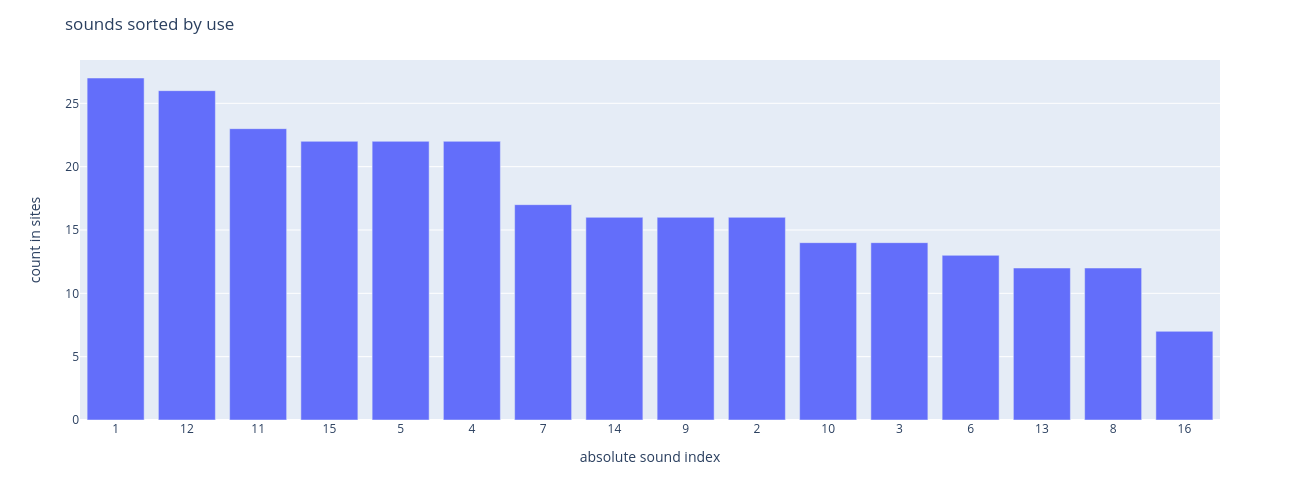

In [18]:
# per site distributions
site_df = df.groupby('siteid').agg('first')
site_dstr = np.stack(site_df['onehot'].values).sum(axis=0)
sorted_dstr = (np.argsort(site_dstr)+1)[::-1]
fig = px.bar(x=[str(i) for i in sorted_dstr], y=site_dstr[sorted_dstr-1])
fig.update_layout(xaxis_title_text='absolute sound index', yaxis_title_text='count in sites',
                  title_text='sounds sorted by use')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

now lets see how many sites I can recruit that contain the selecte sound subset

In [19]:
X = range(1,10)
Y = list()

for x in X:
    sel_set = set(sorted_dstr[:x])
    is_subset = list()
    for ss in site_df.sound_sets:
        is_subset.append(sel_set.issubset(ss))

    Y.append(sum(is_subset))

fig = px.bar(x=X,y=Y)
fig.update_layout(xaxis_title_text="top n sounds in subset", yaxis_title_text="# sites recruited",
                  title_text="# sites with common subset")

#### it seems that **5** a good tradeoff between common sound set size and number of recruited sites
now get the data from the sites that contains the sound subset. find the side wide coverage for the contextual space
defined by the sound subset and quantiffies how much overlap exists between the sites coverage

In [20]:
# get the subset of sites, also marks down what sound indices correspond to the sound subset
sel_set = set(sorted_dstr[:4])
print(f'selected sound subset: {sel_set}')
sel_site_df = site_df.loc[site_df['sound_sets'].apply(lambda x: sel_set.issubset(x)), :].copy()
sel_site_df['internal_idx'] = sel_site_df['Ref_SoundIndexes'].apply(lambda x: [x.index(ss)+1 for ss in sel_set])
sel_site_df['map'] = sel_site_df['Ref_SoundIndexes'].apply(lambda x: {x.index(ss)+1:ss for ss in sel_set})
print(sel_site_df.head())

selected sound subset: {1, 11, 12, 15}
               cellid   rawid                      Ref_SoundIndexes  \
siteid                                                                
TNC006a  TNC006a-05-1  143534  [1, 15, 10, 7, 12, 11, 2, 5, 16, 13]   
TNC008a  TNC008a-01-1  143670   [4, 11, 14, 5, 12, 8, 15, 3, 11, 1]   
TNC009a  TNC009a-13-1  143700    [5, 10, 12, 7, 1, 15, 4, 3, 2, 11]   
TNC012a  TNC012a-01-2  143809    [1, 2, 3, 4, 5, 7, 11, 12, 14, 15]   
TNC016a  TNC016a-07-3  144017  [16, 12, 5, 13, 1, 8, 15, 7, 14, 11]   

                                   sound_sets  set_size  \
siteid                                                    
TNC006a  {1, 2, 5, 7, 10, 11, 12, 13, 15, 16}        10   
TNC008a       {1, 3, 4, 5, 8, 11, 12, 14, 15}         9   
TNC009a    {1, 2, 3, 4, 5, 7, 10, 11, 12, 15}        10   
TNC012a    {1, 2, 3, 4, 5, 7, 11, 12, 14, 15}        10   
TNC016a  {1, 5, 7, 8, 11, 12, 13, 14, 15, 16}        10   

                                                 

#### now filter out real data based on the common sound set

In [21]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
DF = jl.load(summary_DF_file)

DF = DF.query(f"metric == 'integral' and source == 'real' and mult_comp_corr == 'bf_cp' and "
                   f"site in {sel_site_df.index.unique().tolist()}"
                   ).drop(columns=['metric', 'source', 'mult_comp_corr'])

series = DF.iloc[0,:]
def map_rel2abs_sound_index(series):
    # adds zero to the valid sounds since all stim had silence, also zero maps to itself
    internal_idx = set(sel_site_df.loc[series.site, 'internal_idx']).union({0})
    rel2abs = {**sel_site_df.loc[series.site, 'map'], 0:0}

    ctx = [int(cc) for cc in series['context_pair'].split('_')]
    prb = series['probe']

    if set(ctx).issubset(internal_idx) and prb in internal_idx:
        # relative and absolute indices might be flipped for different sites, sort absolute indices for consistency
        ctx_abs = sorted([rel2abs[cc] for cc in ctx])
        ctx_abs = f"{ctx_abs[0]:02}_{ctx_abs[1]:02}"
        prb_abs = f'{rel2abs[prb]:02}'

        return ctx_abs, prb_abs

    else:
        return np.nan, np.nan

DF[['context_pair_absolute', 'probe_absolute']] = DF.apply(map_rel2abs_sound_index, axis=1, result_type='expand')

# eliminate rows not contained in the sound subset
DF.dropna(inplace=True)

# replaces integral values with boolean
DF['signif_bool'] = np.where(DF['value']>0, 1,0)

# since some neurons are not modulated by this subset of souds, drope them to not decrease intersection
coverages = DF.groupby(['site', 'id']).agg(coverage=('signif_bool', np.mean))
mod_neurs = coverages.query("coverage > 0").reset_index().id.tolist()
DF = DF.query(f"id in {mod_neurs}")


## plot 2d histogram of the contextual modulation space
here showing the count of neurons active for each space, for each site
should I look at the proportion instead?

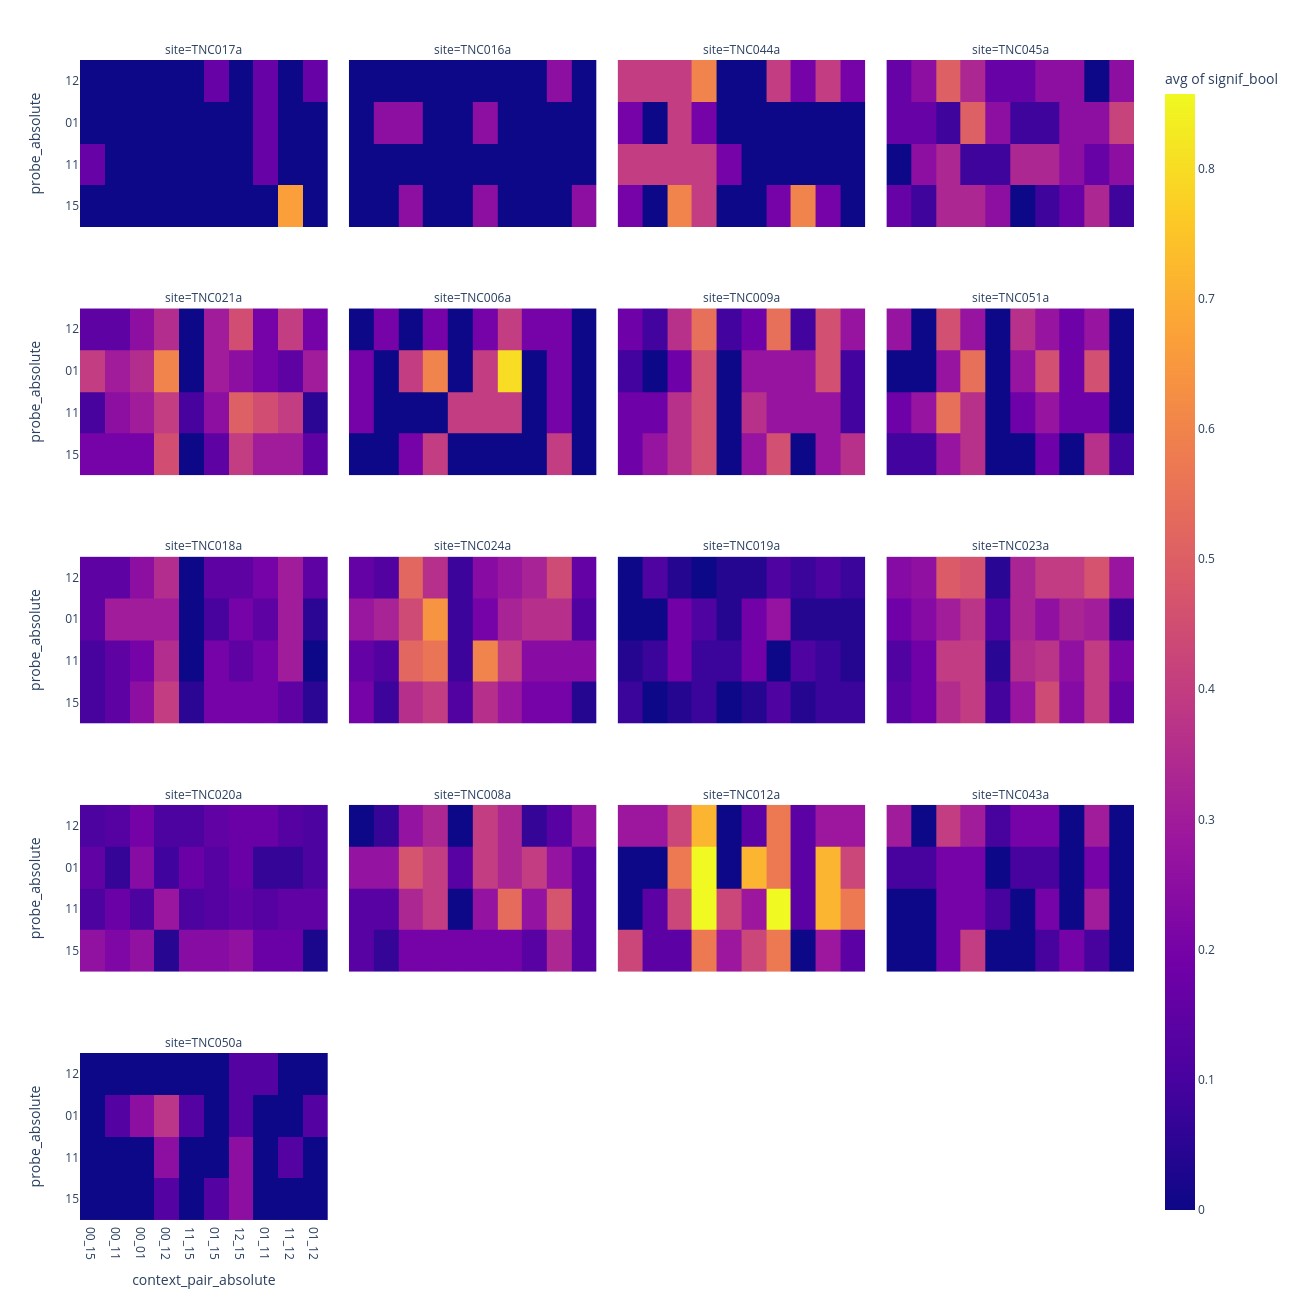

In [22]:
fig = px.density_heatmap(DF,x='context_pair_absolute', y='probe_absolute', z='signif_bool',
                            facet_col='site', facet_col_wrap=4,
                            histfunc='avg')
fig.update_layout(height=1000, width=1000)
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1300)
Image(img_bytes)

# revisit neuronal tiling
how much overlap exists between contextual modulation fields? how much would exists by random?

In [23]:
# pivoted = DF.pivot_table(index=['context_pair', 'probe'], columns=['site', 'id'],
#                          values= 'signif_bool', aggfunc='first')
pivoted = DF.pivot_table(index=['context_pair_absolute', 'probe_absolute'], columns=['site', 'id'],
                         values= 'signif_bool', aggfunc='first')
# pivoted = pivoted[['TNC012a', 'TNC006a']]
pivoted.columns = pivoted.columns.remove_unused_levels()

In [39]:
# for every n-tuple going from 2 to N, calculate the full interesection where N is the #neurons
# for n_tuple in itt.combinations(idxs, r=2):
cover_within_file = pl.Path(config['paths']['analysis_cache']) / f'220422_cover_within_sites'
recache_within = False
if cover_within_file.exists() and not recache_within:
    overlap_df = jl.load(cover_within_file)
else:
    montecarlos = 1000
    overlap_df = list()
    for ss, site in enumerate(pivoted.columns.levels[0]):
        print(f'site {ss}/{len(pivoted.columns.levels[0])}')
        site_df = pivoted[site]
        cell_group = site_df.columns
        for n_neur in tqdm(range(2,len(cell_group)+1)):

            for sel_cells in itt.islice(itt.combinations(cell_group, r=n_neur),0,500):

                # coverage array with shape Neurons x CtxPair-Probe
                cvrg_arr = site_df.loc[:, sel_cells].values.T

                intersection = np.all(cvrg_arr, axis=0).astype(int).sum() / cvrg_arr.shape[1]
                union = np.any(cvrg_arr, axis=0).astype(int).sum() / cvrg_arr.shape[1]

                d = {'intersection': intersection,
                     'union': union,
                     'site': site,
                     'n_neur': n_neur,
                     'source': 'real'}
                overlap_df.append(d)


                ##### montecarlo simulations #####
                # 1. with coverages matched to selected neurons
                neu_cvrgs = cvrg_arr.mean(axis=1)

                # generates all random coverages in a single go
                rndm_cvrgs = np.random.random_sample(size=(cvrg_arr.shape[0],cvrg_arr.shape[1], montecarlos))
                rndm_cvrgs = rndm_cvrgs <= neu_cvrgs[:, np.newaxis, np.newaxis]

                # same as for real data, take mean of motecarlo simulations...
                intersection = np.mean(np.all(rndm_cvrgs, axis=0).sum(axis=0) / rndm_cvrgs.shape[1])
                union = np.mean(np.any(rndm_cvrgs, axis=0).sum(axis=0) / rndm_cvrgs.shape[1])

                d = {'intersection': intersection,
                     'union': union,
                     'site': site,
                     'n_neur': n_neur,
                     'source': 'by_neuron'}

                overlap_df.append(d)

            # 2. with all cell coverages being == to the mean coverage across all neurons
            cvrg_arr = site_df.values.T # Neu x Instance
            avg_covr = cvrg_arr.mean()

            # generates all random coverages in a single go
            rndm_cvrgs = np.random.random_sample(size=(n_neur,cvrg_arr.shape[1], montecarlos))
            rndm_cvrgs = rndm_cvrgs <= avg_covr

              # same as for real data, take mean of motecarlo simulations...
            intersection = np.mean(np.all(rndm_cvrgs, axis=0).sum(axis=0) / rndm_cvrgs.shape[1])
            union = np.mean(np.any(rndm_cvrgs, axis=0).sum(axis=0) / rndm_cvrgs.shape[1])

            d = {'intersection': intersection,
                 'union': union,
                 'site': site,
                 'n_neur': n_neur,
                 'source': 'average'}

            overlap_df.append(d)

    overlap_df = pd.DataFrame(overlap_df)
    jl.dump(overlap_df, cover_within_file)

In [25]:
# get mean and deviations  for all combinations
lines = overlap_df.groupby(['source', 'site', 'n_neur']).agg(int_mean=('intersection',np.mean),
                                                   uni_mean=('union',np.mean),)
                                                   # int_sem=('intersection', sst.sem),
                                                   # uni_sem=('union', sst.sem))
lines = lines.reset_index()

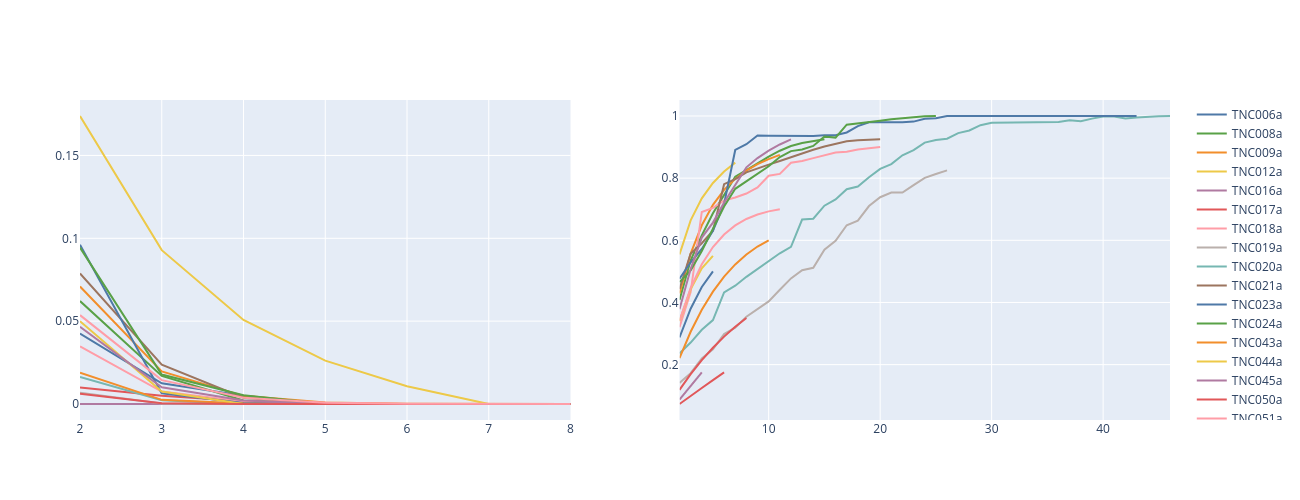

In [42]:
fig = make_subplots(1,2)

for ss, site in enumerate(lines.site.unique()):
    color = ColorList[ss%len(ColorList)]
    toplot = lines.query(f"site == '{site}' and source == 'real'")

    # intersection
    x = toplot['n_neur'].tolist()
    y = toplot['int_mean'].tolist()

    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, name=site, showlegend=False),
                  row=1, col=1)

    # union
    x = toplot['n_neur'].tolist()
    y = toplot['uni_mean'].tolist()

    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, name=site, showlegend=True),
                  row=1, col=2)

fig.update_layout(xaxis_range=[2,8])

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

In [27]:
left = lines.query("source == 'real'").drop(columns=['source'])
right = lines.query("source != 'real'")

full_lines = pd.merge(left, right, on=['site', 'n_neur'], validate='1:m')
full_lines['int_diff'] = full_lines['int_mean_x'] - full_lines['int_mean_y']
full_lines['uni_diff'] = full_lines['uni_mean_x'] - full_lines['uni_mean_y']

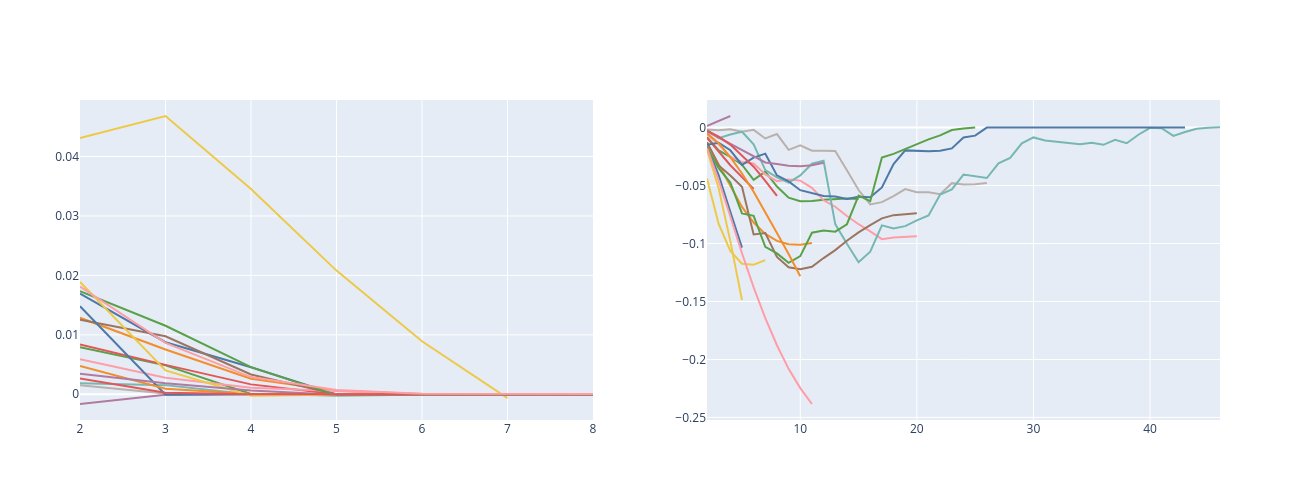

In [43]:
within_fig = make_subplots(1,2)

for ss, site in enumerate(full_lines.site.unique()):
    color = ColorList[ss%len(ColorList)]
    toplot = full_lines.query(f"site == '{site}' and source == 'by_neuron'")

    # intersection
    x = toplot['n_neur'].tolist()
    y = toplot['int_diff'].tolist()

    within_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, name=site, showlegend=False),
                  row=1, col=1)

    # union
    x = toplot['n_neur'].tolist()
    y = toplot['uni_diff'].tolist()

    within_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, name=site, showlegend=False),
                  row=1, col=2)

within_fig.update_layout(xaxis_range=[2,8])

# within_fig.show()
img_bytes = within_fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# what if we compare the overlap between n neurons from n different site?

In [29]:
# for every n-tuple going from 2 to N, calculate the full interesection where N is the #neurons
# for n_tuple in itt.combinations(idxs, r=2):
cover_between_file = pl.Path(config['paths']['analysis_cache']) / f'220422_cover_between_sites'
recache_between = False

if cover_between_file.exists() and not recache_between:
    diff_site_overlap_df = jl.load(cover_between_file)
else:
    diff_site_overlap_df = list()
    n_subsamps = 500
    montecarlo = 1000
    # we are limmited by the number of different sites to select different neurons
    for n_neur in tqdm(range(2,len(pivoted.columns.levels[0])+1)):

        for ns in range(n_subsamps):
            sel_sites = np.random.choice(pivoted.columns.levels[0], size=n_neur, replace=False)

            sel_cells = list()
            for site in sel_sites:
                sel_cells.append(np.random.choice(pivoted[site].columns,
                                                  size=1)[0])

            # real deal
            cvrg_arr = pivoted[zip(sel_sites, sel_cells)].values.T
            intersection = np.all(cvrg_arr, axis=0).astype(int).sum() / cvrg_arr.shape[1]
            union = np.any(cvrg_arr, axis=0).astype(int).sum() / cvrg_arr.shape[1]

            d = {'intersection': intersection,
                 'union': union,
                 'n_subsamps': ns,
                 'n_neur': n_neur,
                 'source': 'real'}
            diff_site_overlap_df.append(d)

            # random
            cvrgs = cvrg_arr.mean(axis=1)

            # generates all random coverages in a single go
            rndm_cvrgs = np.random.random_sample(size=(cvrg_arr.shape[0],cvrg_arr.shape[1], montecarlo))
            rndm_cvrgs = rndm_cvrgs <= cvrgs[:, np.newaxis, np.newaxis]

            # just take the mean for now
            intersection = np.mean(np.all(rndm_cvrgs, axis=0).astype(int).sum(axis=0) / rndm_cvrgs.shape[1])
            union = np.mean(np.any(rndm_cvrgs, axis=0).astype(int).sum(axis=0) / rndm_cvrgs.shape[1])

            # # closed form solution??
            # intersection = np.prod(cvrgs)
            # union = np.sum(cvrgs) - intersection

            d = {'intersection': intersection,
                 'union': union,
                 'n_subsamps': ns,
                 'n_neur': n_neur,
                 'source': 'by_neuron'}

            diff_site_overlap_df.append(d)

            # 2. with all cell coverages being == to the mean coverage
            avg_covr = cvrgs.mean()
            rndm_cvrgs = rndm_cvrgs <= avg_covr
            intersection = np.mean(np.all(rndm_cvrgs, axis=0).astype(int).sum(axis=0) / rndm_cvrgs.shape[1])
            union = np.mean(np.any(rndm_cvrgs, axis=0).astype(int).sum(axis=0) / rndm_cvrgs.shape[1])

            d = {'intersection': intersection,
                 'union': union,
                 'n_subsamps': ns,
                 'n_neur': n_neur,
                 'source': 'average'}

            diff_site_overlap_df.append(d)

    diff_site_overlap_df = pd.DataFrame(diff_site_overlap_df)
    jl.dump(diff_site_overlap_df, cover_between_file)


100%|██████████| 16/16 [00:51<00:00,  3.24s/it]


In [30]:
diff_lines = diff_site_overlap_df.groupby(['source', 'n_neur']).agg(int_mean=('intersection',np.mean),
                                                   uni_mean=('union',np.mean),)
                                                   # int_sem=('intersection', sst.sem),
                                                   # uni_sem=('union', sst.sem))
diff_lines = diff_lines.reset_index()

left = diff_lines.query("source == 'real'").drop(columns=['source'])
right = diff_lines.query("source != 'real'")
full_diff_lines = pd.merge(left, right, on=['n_neur'], validate='1:m')
full_diff_lines['int_diff'] = full_diff_lines['int_mean_x'] - full_diff_lines['int_mean_y']
full_diff_lines['uni_diff'] = full_diff_lines['uni_mean_x'] - full_diff_lines['uni_mean_y']

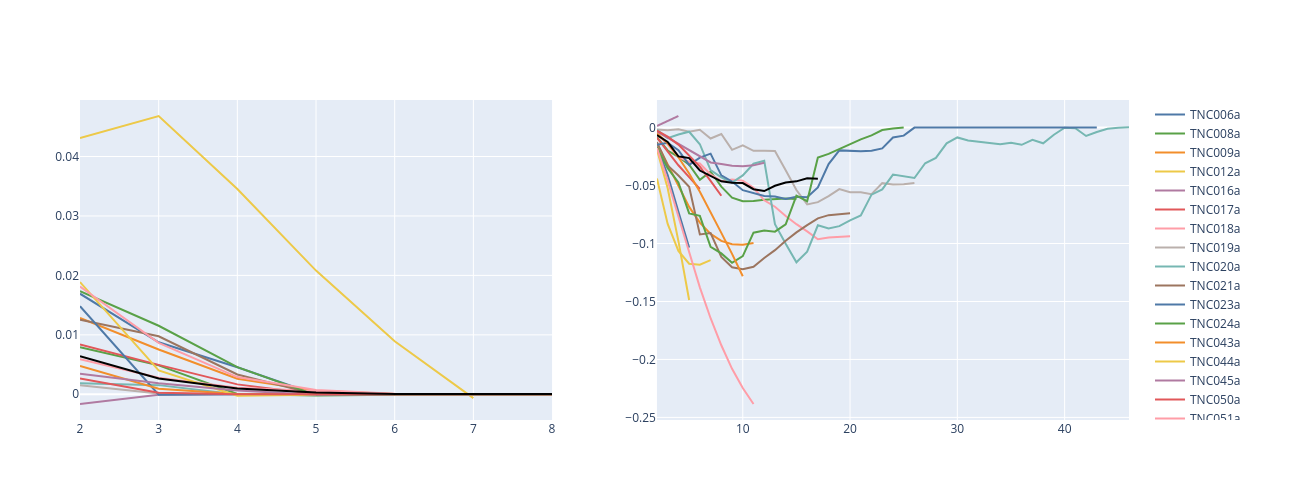

In [44]:
within_fig = make_subplots(1,2)
for ss, site in enumerate(full_lines.site.unique()):
    color = ColorList[ss%len(ColorList)]
    toplot = full_lines.query(f"site == '{site}' and source == 'by_neuron'")

    # intersection
    x = toplot['n_neur'].tolist()
    y = toplot['int_diff'].tolist()

    within_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, name=site, showlegend=True),
                  row=1, col=1)

    # union
    x = toplot['n_neur'].tolist()
    y = toplot['uni_diff'].tolist()

    within_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, name=site, showlegend=False),
                  row=1, col=2)

##### between sites
# intersection
toplot = full_diff_lines.query("source == 'by_neuron'")
x = toplot['n_neur'].tolist()
y = toplot['int_diff'].tolist()

within_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color='black', name='int_diff_between', showlegend=True),
              row=1, col=1)

# union
x = toplot['n_neur'].tolist()
y = toplot['uni_diff'].tolist()

within_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color='black', name='int_diff_between', showlegend=False),
              row=1, col=2)


within_fig.update_layout(xaxis_range=[2,8])
# within_fig.show()
img_bytes = within_fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# in conclussion
raw interseciton and union follow the idea that neurons in the same site tend to be tunned together and have
an overlaping more than random contextual modulation field.

Same applies to neurons coming from different sites, hoever in this case the overlap while greater than random,
is smaller than the overlap in neurons from the same site

# Tuning vector analysis
we might be better at finding differences in tuning if instead of intersections of booleans we focus on the strength
of tunning itself

In [32]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
DF = jl.load(summary_DF_file).query(f"metric == 'integral' and source == 'real' and mult_comp_corr == 'bf_cp'"
                                    ).drop(columns=['metric', 'source', 'mult_comp_corr'])

ctx_fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220427_probe_firerates'
DF_prb_fr = jl.load(ctx_fr_DF_file)

In [59]:
def get_mod_tuning(cellid):
    cell_df =  DF.query(f"id == '{cellid}'")
    tunning_vector = cell_df.value.values
    piv = cell_df.pivot(index='context_pair',columns='probe', values='value')

    # I could make this smart, but lets not worry about itfor now
    n_ctx = 11
    n_prb = 10

    tuning_tensor = np.full([n_ctx, n_ctx, n_prb], fill_value=np.nan)
    for rr, row in piv.iterrows():
        ctx_idx = [int(cc) for cc in rr.split('_')]
        for cc, val in row.iteritems():
            prb_idx = cc-1
            tuning_tensor[ctx_idx[0], ctx_idx[1], prb_idx] = val
            tuning_tensor[ctx_idx[1], ctx_idx[0], prb_idx] = val

    return tuning_tensor, tunning_vector


def marginal_tunings(cellid):
    tuning_tensor, tuning_vector = get_mod_tuning(cellid)
    # tensor has shape ctx x ctx x prb
    tuning_vctr = DF_prb_fr.query(f"id == '{cellid}' and part == 'probe'")
    print(tuning_vctr.chunk.unique())

    fig = make_subplots(1, 3, subplot_titles=['ctx_pair marginal', 'ctx-prb marginal', 'tunnings'],
                        specs= [[{}, {}, {'secondary_y':True}]])
    fig.add_traces(px.imshow(np.nanmean(tuning_tensor, axis=2))['data'], rows=1, cols=1)

    # fig.add_traces(px.imshow(np.nanmean(tuning_tensor, axis=0),
    #                          x=list(range(1,11)), y=list(range(11))
    #                          )['data'], rows=1, cols=2)

    fig.add_traces(px.imshow(np.nanmean(tuning_tensor, axis=0).T,
                         x=list(range(11)), y=list(range(1,11))
                         )['data'], rows=1, cols=2)

    fig.add_trace(go.Scatter(x=list(range(11)),y=np.nanmean(tuning_tensor, axis=(1,2)),
                             name='modulation'),
                  row=1, col=3)
    fig.add_trace(go.Scatter(x=tuning_vctr['probe'],y=tuning_vctr['value'],
                             name='tuning'),
                  row=1, col=3, secondary_y=True)

    fig.update_layout(xaxis_title_text='context', yaxis_title_text='context',
                      xaxis2_title_text='context', yaxis2_title_text='probe',
                      yaxis3_title_text='modulation', yaxis4_title_text='tunning',
                      title_text=cellid)

    return fig

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/tmp/ipykernel_10970/4255472684.py:29: RuntimeWarning:

Mean of empty slice



['A' 'B' 'C' 'D']


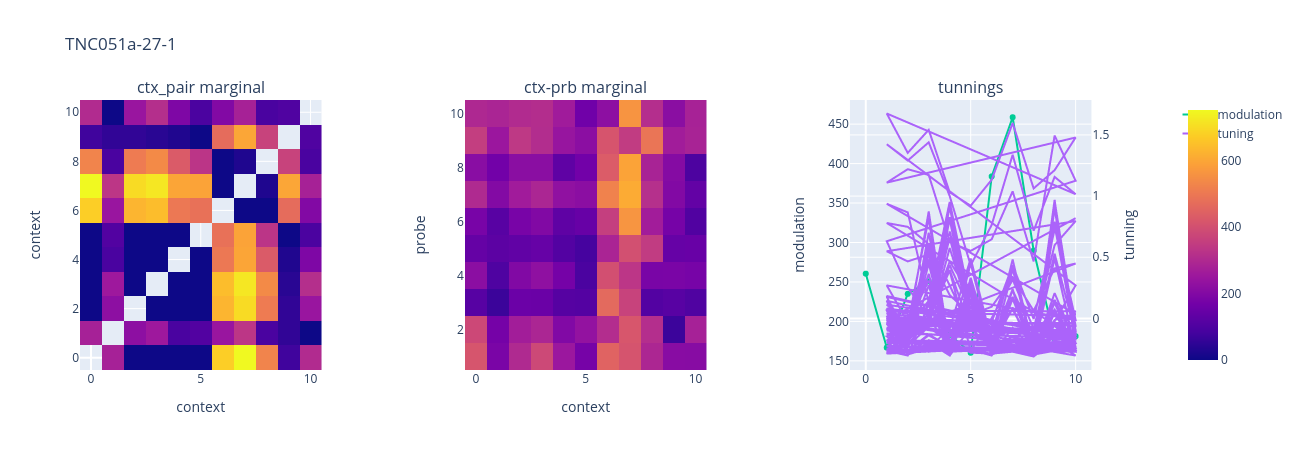

In [60]:

cellid = 'TNC051a-27-1'
fig = marginal_tunings(cellid)
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=450)
Image(img_bytes)

/tmp/ipykernel_10970/821543093.py:27: RuntimeWarning:

Mean of empty slice



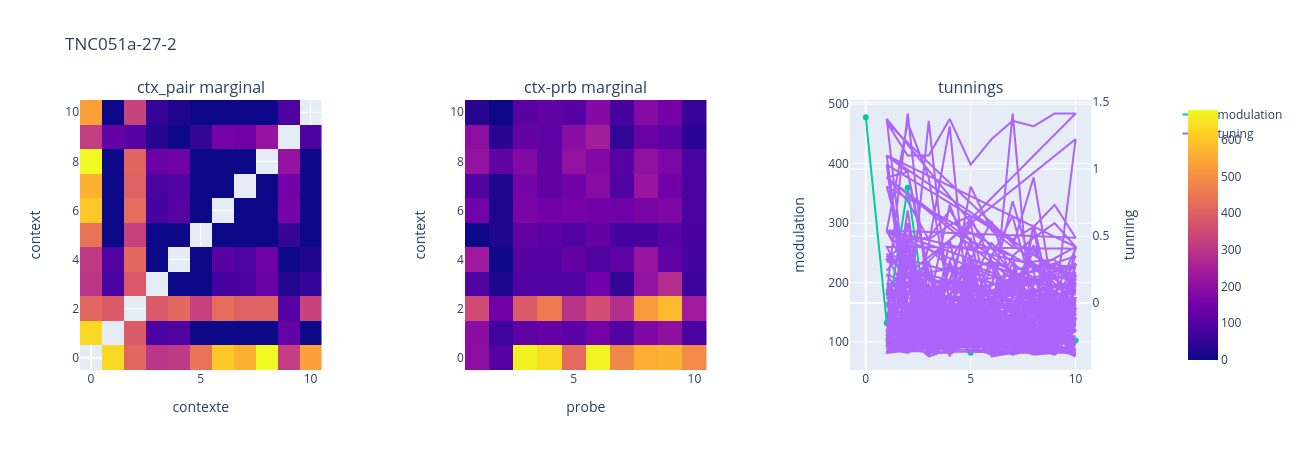

In [35]:
cellid = 'TNC051a-27-2'
fig = marginal_tunings(cellid)
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=450)
Image(img_bytes)

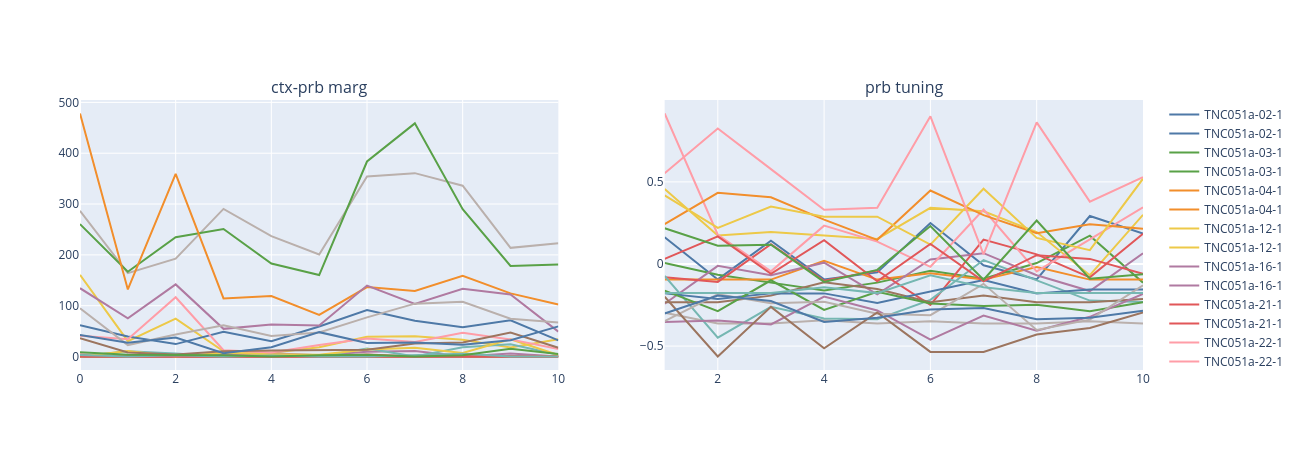

In [36]:
# lets get multiple marignals and tunning for neurons in the same site
site = cellid.split('-')[0]
site = 'TNC051a'
site_df = DF.query(f"site == '{site}'")

fig = make_subplots(1, 2, subplot_titles=['ctx-prb marg', 'prb tuning'])

for cc, cell in enumerate(site_df.id.unique()):
    mod_tensor, _ = get_mod_tuning(cell)
    prb_vctr = DF_prb_fr.query(f"id == '{cell}'")['value'].values

    color = ColorList[cc%len(ColorList)]
    # modulation
    x = list(range(11))
    y = np.nanmean(mod_tensor, axis=(1,2))
    fig.add_trace(go.Scatter(x=x,y=y, mode='lines', name=cell, line_color=color), row=1, col=1)

    # probe tuning
    x = list(range(1,11))
    y = prb_vctr
    fig.add_trace(go.Scatter(x=x,y=y, mode='lines', name=cell, line_color=color), row=1, col=2)


# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=450)
Image(img_bytes)

## Sadness
If anyting, it seems that the tunning is more variable than the contextual modulation
lets use the full modulation vector, and some undestandable measure of similarity

In [37]:
def cos_sim(a,b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))



# calculates pairwise cosine similarity between neurons in a site
sim_df = list()
cellpairs = list(itt.combinations(site_df.id.unique(), r=2))
for cell0, cell1 in tqdm(cellpairs):

    # modulation similarity
    _, mod_vector0 = get_mod_tuning(cell0)
    _, mod_vector1 = get_mod_tuning(cell1)
    mod_sim = cos_sim(mod_vector0, mod_vector1)

    # tunning similarity
    tune_vctr0 = DF_prb_fr.query(f"id == '{cell0}'")['value'].values
    tune_vctr1 = DF_prb_fr.query(f"id == '{cell1}'")['value'].values
    tune_sim = cos_sim(tune_vctr0, tune_vctr1)

    d = {'neuron_pair': f'{cell0}_{cell1}',
         'mod_sim': mod_sim,
         'tune_sim': tune_sim}

    sim_df.append(d)

sim_df = pd.DataFrame(sim_df)

  0%|          | 0/231 [00:00<?, ?it/s]/tmp/ipykernel_10970/1466547071.py:2: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 231/231 [00:14<00:00, 16.09it/s]


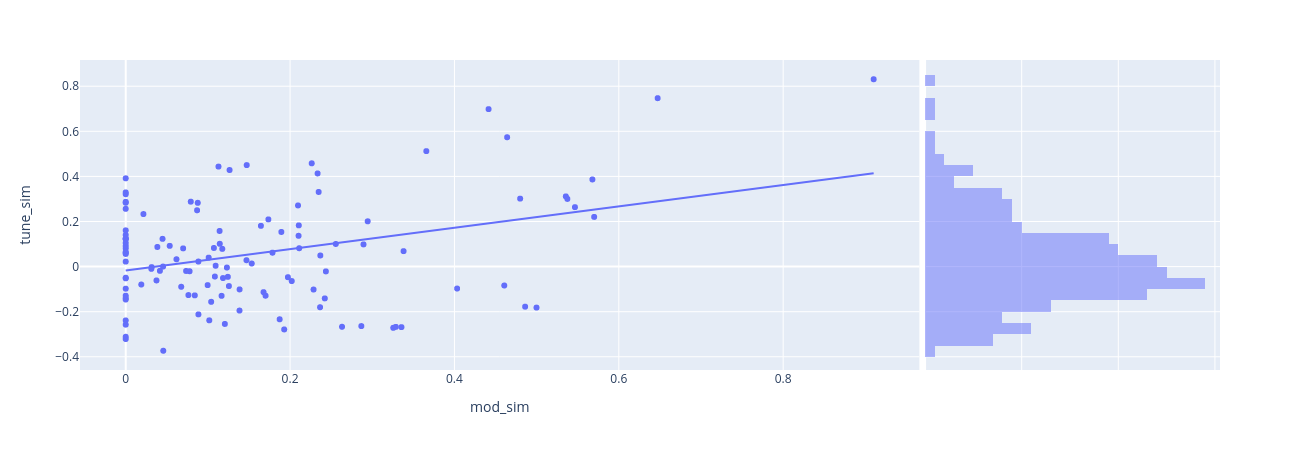

In [38]:
fig = px.scatter(data_frame=sim_df, x='mod_sim', y='tune_sim', hover_name='neuron_pair',
                 marginal_y='histogram',  trendline="ols")
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=450)
Image(img_bytes)